In [ ]:
## this code is run on the google collab after uploding the images
# link of the combine data set of HAM10000 and ISIC 2019
https://drive.google.com/file/d/16T1LSrSrAdmnXVr3jThWYGt-LSMVIPWu/view?usp=share_link

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 10.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import random
import plotly.express as px

In [ ]:
!pip install pyunpack


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/final_year/output.zip').extractall('/content')

In [ ]:
train_dir = Path("/content/output/train")
train_filepaths = list(train_dir.glob(r'**/*.*'))

test_dir = Path(("/content/output/test"))
test_filepaths = list(test_dir.glob(r'**/*.*'))

val_dir = Path(("/content/output/val"))
val_filepaths = list(test_dir.glob(r'**/*.*'))

In [ ]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 11909

Number of different labels: 8

Labels: ['df' 'vasc' 'bcc' 'mel' 'nv' 'akiec' 'bkl' 'train']


In [ ]:
train_df.Label.unique()

array(['df', 'vasc', 'bcc', 'mel', 'nv', 'akiec', 'bkl', 'train'],
      dtype=object)

In [ ]:
import tensorflow as tf

# Load the saved model from the SavedModel format
model = tf.keras.models.load_model('path/to/saved_model')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
train_df['Label']='train'

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 11908 validated image filenames belonging to 7 classes.
Found 1495 validated image filenames belonging to 7 classes.
Found 1495 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

pretrained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50
 15/373 [>.............................] - ETA: 52s - loss: 5.7645 - accuracy: 0.2188

KeyboardInterrupt: ignored

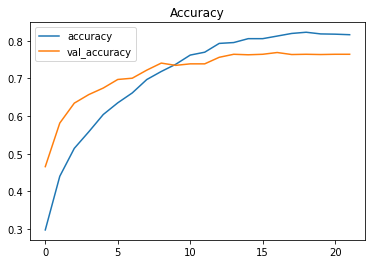

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


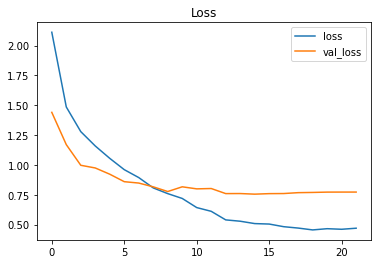

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.savefig('loss-graph.png')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3

pretrained_model = EfficientNetV2B3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(524, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50
373/373 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.5033
Epoch 1: val_loss improved from inf to 0.99332, saving model to /content/model/model.h5
373/373 [==============================] - 59s 127ms/step - loss: 1.2803 - accuracy: 0.5033 - val_loss: 0.9933 - val_accuracy: 0.6281 - lr: 1.0000e-04
Epoch 2/50
373/373 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.6102
Epoch 2: val_loss improved from 0.99332 to 0.90050, saving model to /content/model/model.h5
373/373 [==============================] - 45s 122ms/step - loss: 1.0156 - accuracy: 0.6102 - val_loss: 0.9005 - val_accuracy: 0.6609 - lr: 1.0000e-04
Epoch 3/50
373/373 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6413
Epoch 3: val_loss improved from 0.90050 to 0.85431, saving model to /content/model/model.h5
373/373 [==============================] - 46s 124ms/step - loss: 0.9361 - accuracy: 0.6413 - val_loss: 0.8543 - val_accuracy: 0.6742 - lr

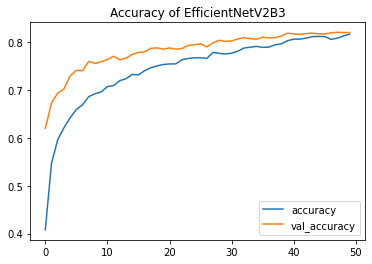

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy of EfficientNetV2B3")
plt.show()


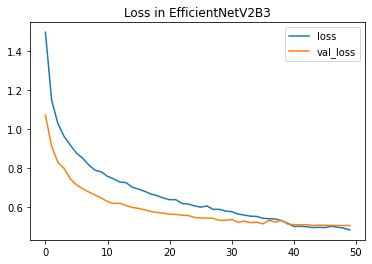

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss in EfficientNetV2B3")
plt.savefig('loss-graph.png')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential

# Define the input shape
input_shape = (224, 224, 3)

# Define the number of classes
num_classes = 7

# Define the model architecture
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 26, 26, 64)      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)

Epoch 1/50
745/745 [==============================] - ETA: 0s - loss: 2.2085 - accuracy: 0.2395
Epoch 1: val_loss improved from inf to 1.72306, saving model to /content/model/model.h5
745/745 [==============================] - 34s 43ms/step - loss: 2.2085 - accuracy: 0.2395 - val_loss: 1.7231 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 2/50
745/745 [==============================] - ETA: 0s - loss: 1.7680 - accuracy: 0.2717
Epoch 2: val_loss did not improve from 1.72306
745/745 [==============================] - 34s 46ms/step - loss: 1.7680 - accuracy: 0.2717 - val_loss: 1.8775 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 3/50
744/745 [============================>.] - ETA: 0s - loss: 1.7009 - accuracy: 0.3062
Epoch 3: val_loss improved from 1.72306 to 1.61449, saving model to /content/model/model.h5
745/745 [==============================] - 31s 41ms/step - loss: 1.7009 - accuracy: 0.3062 - val_loss: 1.6145 - val_accuracy: 0.3619 - lr: 0.0010
Epoch 4/50
745/745 [===========================

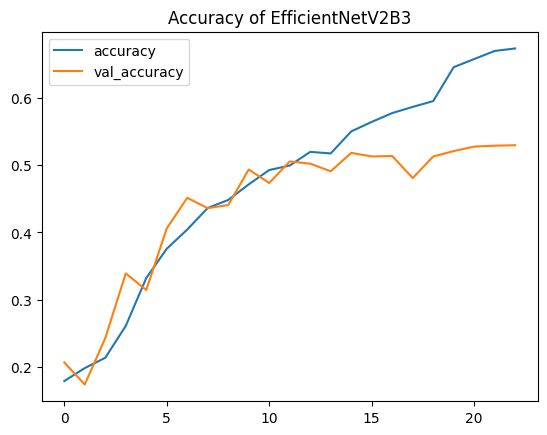

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy of EfficientNetV2B3")
plt.show()



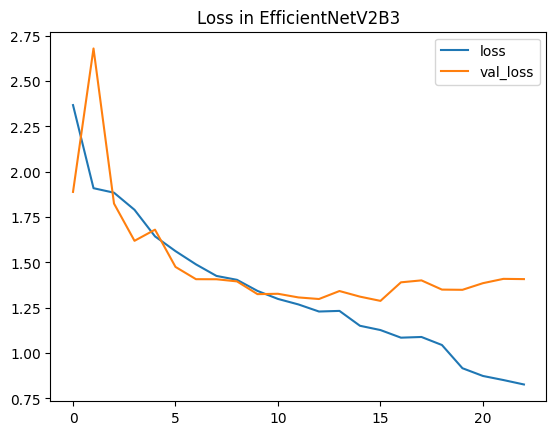

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss in EfficientNetV2B3")
plt.savefig('loss-graph.png')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
373/373 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.5708
Epoch 1: val_loss improved from inf to 0.82292, saving model to /content/model/model.h5
373/373 [==============================] - 100s 230ms/step - loss: 1.1482 - accuracy: 0.5708 - val_loss: 0.8229 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 2/50
373/373 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6961
Epoch 2: val_loss improved from 0.82292 to 0.71528, saving model to /content/model/model.h5
373/373 [==============================] - 90s 240ms/step - loss: 0.8147 - accuracy: 0.6961 - val_loss: 0.7153 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 3/50
373/373 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7393
Epoch 3: val_loss improved from 0.71528 to 0.66093, saving model to /content/model/model.h5
373/373 [==============================] - 83s 223ms/step - loss: 0.7070

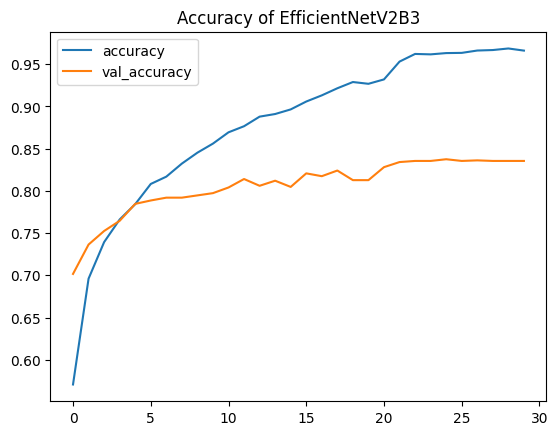

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy of EfficientNetV2B3")
plt.show()

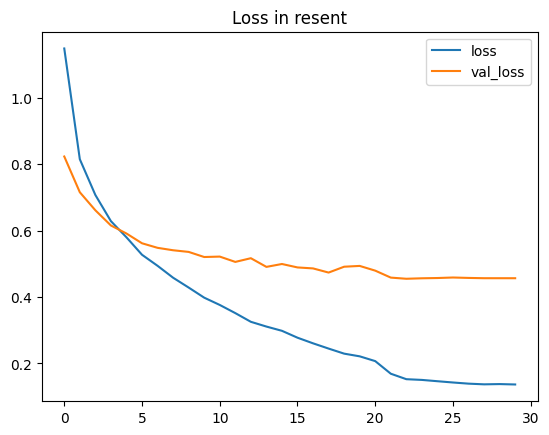

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss in resent")

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19

pretrained_model = VGG19(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/VGG19_model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=30,
                    callbacks=callbacks)

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/30
373/373 [==============================] - ETA: 0s - loss: 1.6728 - accuracy: 0.4319
Epoch 1: val_loss improved from inf to 0.99655, saving model to /content/model/VGG19_model.h5
373/373 [==============================] - 140s 352ms/step - loss: 1.6728 - accuracy: 0.4319 - val_loss: 0.9965 - val_accuracy: 0.6348 - lr: 1.0000e-04
Epoch 2/30
373/373 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.5925
Epoch 2: val_loss improved from 0.99655 to 0.88078, saving model to /content/model/VGG19_model.h5
373/373 [==============================] - 124s 332ms/step - loss: 1.1157 - accuracy: 0.5925 - val_loss: 0.8808 - val_accuracy: 0.6809 - lr: 1.0000e-04
Epoch 3/30
373/373 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.6490
Epoch 3: val_loss improved from 0.88078 to 0.81170, saving model to /content/model/VGG19_model.h5
373/373 [==============================] - 131s 352ms

In [ ]:
import tensorflow
from keras.layers import Input, Flatten, Dense,Dropout
from keras.models import Model
from keras.layers import concatenate
from keras.applications import ResNet50
from keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# number of classes
num_classes = 7

# input tensor
input_tensor = Input(shape=(224, 224, 3))

# ResNet50 model
resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG19 model
vgg_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)

# freeze layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# flatten the output of both models
resnet_output = Flatten()(resnet_model.output)
vgg_output = Flatten()(vgg_model.output)

# concatenate the output of both models
concatenated = concatenate([resnet_output, vgg_output])

# fully connected layer
fc1 = Dense(1024, activation='relu')(concatenated)
output = Dropout(0.4)(fc1)
# output layer
output = Dense(num_classes, activation='softmax')(output)

# create the model
model = Model(inputs=input_tensor, outputs=output)
ckpt = ModelCheckpoint('/content/model/VGG19_resnet_model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=30,
                    callbacks=callbacks)


Epoch 1/30
373/373 [==============================] - ETA: 0s - loss: 7.8423 - accuracy: 0.5055
Epoch 1: val_loss improved from inf to 0.96755, saving model to /content/model/VGG19_resnet_model.h5
373/373 [==============================] - 137s 356ms/step - loss: 7.8423 - accuracy: 0.5055 - val_loss: 0.9675 - val_accuracy: 0.6368 - lr: 0.0010
Epoch 2/30
373/373 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.5894
Epoch 2: val_loss improved from 0.96755 to 0.96094, saving model to /content/model/VGG19_resnet_model.h5
373/373 [==============================] - 130s 348ms/step - loss: 1.0772 - accuracy: 0.5894 - val_loss: 0.9609 - val_accuracy: 0.6381 - lr: 0.0010
Epoch 3/30
373/373 [==============================] - ETA: 0s - loss: 0.9583 - accuracy: 0.6340
Epoch 3: val_loss improved from 0.96094 to 0.84680, saving model to /content/model/VGG19_resnet_model.h5
373/373 [==============================] - 138s 370ms/step - loss: 0.9583 - accuracy: 0.6340 - val_loss: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

pretrained_model = VGG16(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/vgg16_model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)


Epoch 1/50
373/373 [==============================] - ETA: 0s - loss: 1.4109 - accuracy: 0.5116
Epoch 1: val_loss improved from inf to 0.90090, saving model to /content/model/vgg16_model.h5
373/373 [==============================] - 78s 166ms/step - loss: 1.4109 - accuracy: 0.5116 - val_loss: 0.9009 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 2/50
373/373 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.6549
Epoch 2: val_loss improved from 0.90090 to 0.80313, saving model to /content/model/vgg16_model.h5
373/373 [==============================] - 58s 156ms/step - loss: 0.9309 - accuracy: 0.6549 - val_loss: 0.8031 - val_accuracy: 0.7144 - lr: 1.0000e-04
Epoch 3/50
373/373 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.7087
Epoch 3: val_loss improved from 0.80313 to 0.76566, saving model to /content/model/vgg16_model.h5
373/373 [==============================] - 57s 152ms/step - loss: 0.7803 - accuracy: 0.7087 - val_loss: 0.7657 - val_acc

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3

pretrained_model = EfficientNetV2B3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = tf.keras.layers.Dense(524, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)



Epoch 1/50
373/373 [==============================] - ETA: 0s - loss: 1.3413 - accuracy: 0.4667
Epoch 1: val_loss improved from inf to 0.98396, saving model to /content/model/model.h5
373/373 [==============================] - 66s 145ms/step - loss: 1.3413 - accuracy: 0.4667 - val_loss: 0.9840 - val_accuracy: 0.6274 - lr: 1.0000e-04
Epoch 2/50
373/373 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.5810
Epoch 2: val_loss improved from 0.98396 to 0.88054, saving model to /content/model/model.h5
373/373 [==============================] - 45s 122ms/step - loss: 1.0551 - accuracy: 0.5810 - val_loss: 0.8805 - val_accuracy: 0.6649 - lr: 1.0000e-04
Epoch 3/50
373/373 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.6274
Epoch 3: val_loss improved from 0.88054 to 0.83408, saving model to /content/model/model.h5
373/373 [==============================] - 47s 125ms/step - loss: 0.9641 - accuracy: 0.6274 - val_loss: 0.8341 - val_accuracy: 0.6870 - lr

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7

pretrained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

for layer in pretrained_model.layers:
    layer.trainable = False

inputs = pretrained_model.input
x = pretrained_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]

# Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callbacks)



258076736/258076736 [==============================] - 12s 0us/step
Epoch 1/50
373/373 [==============================] - ETA: 0s - loss: 1.3747 - accuracy: 0.4789
Epoch 1: val_loss improved from inf to 1.13305, saving model to /content/model/model.h5
373/373 [==============================] - 184s 437ms/step - loss: 1.3747 - accuracy: 0.4789 - val_loss: 1.1330 - val_accuracy: 0.5585 - lr: 1.0000e-04
Epoch 2/50
373/373 [==============================] - ETA: 0s - loss: 1.1276 - accuracy: 0.5797
Epoch 2: val_loss improved from 1.13305 to 1.01584, saving model to /content/model/model.h5
373/373 [==============================] - 156s 419ms/step - loss: 1.1276 - accuracy: 0.5797 - val_loss: 1.0158 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 3/50
373/373 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.6088
Epoch 3: val_loss improved from 1.01584 to 0.94852, saving model to /content/model/model.h5
373/373 [==============================] - 156s 417ms/step - loss: 1

In [ ]:
print(tf. __version__) 

2.12.0


In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

In [ ]:
# Define the callbacks
ckpt = ModelCheckpoint('/content/model/model.h5',
                        monitor='val_loss', save_best_only=True, verbose=3)

estop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [ckpt, estop, lr]
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=50,
                    callbacks=callback)